# Efficent Marginals Computation

GTSAM can very efficiently calculate marginals in Bayes trees. In this post, we illustrate the “shortcut” mechanism for **caching** the conditional distribution $P(S \mid R)$ in a Bayes tree, allowing efficient other marginal queries. We assume familiarity with **Bayes trees** from [the previous post](#).

## Toy Example

We create a small Bayes tree:

\begin{equation}
P(a \mid b) P(b,c \mid r) P(f \mid e) P(d,e \mid r) P(r).
\end{equation}

Below is some Python code (using GTSAM’s discrete wrappers) to define and build the corresponding Bayes tree. We'll use a discrete example, i.e., we'll create a `DiscreteBayesTree`.


In [1]:
from gtsam import DiscreteConditional, DiscreteBayesTree, DiscreteBayesTreeClique, DecisionTreeFactor

In [2]:
# Make discrete keys (key in elimination order, cardinality):
keys = [(0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2)]
names = {0: 'a', 1: 'f', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'r'}
aKey, fKey, bKey, cKey, dKey, eKey, rKey = keys
keyFormatter = lambda key: names[key]

In [3]:
# 1. Root Clique: P(r)
cliqueR = DiscreteBayesTreeClique(DiscreteConditional(rKey, "0.4/0.6"))

# 2. Child Clique 1: P(b, c | r)
cliqueBC = DiscreteBayesTreeClique(
    DiscreteConditional(
        2, DecisionTreeFactor([bKey, cKey, rKey], "0.3 0.7 0.1 0.9 0.2 0.8 0.4 0.6")
    )
)

# 3. Child Clique 2: P(d, e | r)
cliqueDE = DiscreteBayesTreeClique(
    DiscreteConditional(
        2, DecisionTreeFactor([dKey, eKey, rKey], "0.1 0.9 0.9 0.1 0.2 0.8 0.3 0.7")
    )
)

# 4. Leaf Clique from Child 1: P(a | b)
cliqueA = DiscreteBayesTreeClique(DiscreteConditional(aKey, [bKey], "1/3 3/1"))

# 5. Leaf Clique from Child 2: P(f | e)
cliqueF = DiscreteBayesTreeClique(DiscreteConditional(fKey, [eKey], "1/3 3/1"))

In [4]:
# Build the BayesTree:
bayesTree = DiscreteBayesTree()

# Insert root:
bayesTree.insertRoot(cliqueR)

# Attach child cliques to root:
bayesTree.addClique(cliqueBC, cliqueR)
bayesTree.addClique(cliqueDE, cliqueR)

# Attach leaf cliques:
bayesTree.addClique(cliqueA, cliqueBC)
bayesTree.addClique(cliqueF, cliqueDE)

# bayesTree.print("bayesTree", keyFormatter)

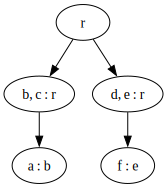

In [5]:
import graphviz
graphviz.Source(bayesTree.dot(keyFormatter))

## Naive Computation of P(a)
The marginal $P(a)$ can be computed by summing out the other variables in the tree:
$$
P(a) = \sum_{b, c, d, e, f, r} P(a, b, c, d, e, f, r)
$$

Using the Bayes tree structure, we have

$$
P(a) = \sum_{b, c, d, e, f, r} P(a \mid b) P(b, c \mid r) P(f \mid e) P(d, e \mid r) P(r)  
$$

but we can ignore variables $e$ and $f$ not on the path from $a$ to the root $r$. Indeed, by associativity we have

$$
P(a) = \sum_{r} \Bigl\{ \sum_{e,f} P(f \mid e) P(d, e \mid r) \Bigr\} \sum_{b, c, d} P(a \mid b) P(b, c \mid r) P(r)
$$

where the grouped terms sum to one for any value of $r$, and hence

$$
P(a) = \sum_{r, b, c, d} P(a \mid b) P(b, c \mid r) P(r).
$$

## Memoization via Shortcuts

In GTSAM, we compute this recursively

#### Step 1
We want to compute the marginal via
$$
P(a) = \sum_{r, b} P(a \mid b) P(b).
$$
where $P(b)$ is the separator of this clique.

#### Step 2
To compute the separator marginal, we use the **shortcut** $P(b|r)$:
$$
P(b) = \sum_{r} P(b \mid r) P(r).
$$
In general, a shortcut $P(S|R)$ directly conditions this clique's separator $S$ on the root clique $R$, even if there are many other cliques in-between. That is why it is called a *shortcut*.

#### Step 3 (optional)
If the shortcut was already computed, then we are done! If not, we compute it recursively:
$$
P(S\mid R) = \sum_{F_p,\,S_p \setminus S}P(F_p \mid S_p) P(S_p \mid R).
$$
Above $P(F_p \mid S_p)$ is the parent clique, and by the running intersection property we know that the seprator $S$ is a subset of the parent clique's variables.
Note that the recursion is because we might not have $P(S_p \mid R)$ yet, so it might have to be computed in turn, etc. The recursion ends at nodes below the root, and **after we have obtained $P(S\mid R)$ we cache it**.

In our example, the computation is simply
$$
P(b|r) = \sum_{c} P(b, c \mid r),
$$
because this the parent separator is already the root, so $P(S_p \mid R)$ is omitted. This is also the end of the recursion.


In [6]:
# Marginal of the leaf variable 'a':
print(bayesTree.numCachedSeparatorMarginals())
marg_a = bayesTree.marginalFactor(aKey[0])
print("Marginal P(a):\n", marg_a)
print(bayesTree.numCachedSeparatorMarginals())


0
Marginal P(a):
 Discrete Conditional
 P( 0 ):
 Choice(0) 
 0 Leaf 0.51
 1 Leaf 0.49


3


In [7]:

# Marginal of the internal variable 'b':
print(bayesTree.numCachedSeparatorMarginals())
marg_b = bayesTree.marginalFactor(bKey[0])
print("Marginal P(b):\n", marg_b)
print(bayesTree.numCachedSeparatorMarginals())


3
Marginal P(b):
 Discrete Conditional
 P( 2 ):
 Choice(2) 
 0 Leaf 0.48
 1 Leaf 0.52


3


In [8]:

# Joint of leaf variables 'a' and 'f': P(a, f)
# This effectively needs to gather info from two different branches
print(bayesTree.numCachedSeparatorMarginals())
marg_af = bayesTree.jointBayesNet(aKey[0], fKey[0])
print("Joint P(a, f):\n", marg_af)
print(bayesTree.numCachedSeparatorMarginals())


3
Joint P(a, f):
 DiscreteBayesNet
 
size: 2
conditional 0:  P( 0 | 1 ):
 Choice(1) 
 0 Choice(0) 
 0 0 Leaf 0.51758893
 0 1 Leaf 0.48241107
 1 Choice(0) 
 1 0 Leaf 0.50222672
 1 1 Leaf 0.49777328

conditional 1:  P( 1 ):
 Choice(1) 
 0 Leaf 0.506
 1 Leaf 0.494


3
